## Cycling Schedule Predictor

### Aim
I don't want to say I'm a fair weather cyclist but my days of riding through heavy rain or having to combat brutal headwinds in the name of fitness are reaching an end. Using weather data sourced from the Australian Bureau of Meterology along with my personal cycling data retrieved from Strava (an exercise app), I will develop a model that can review the upcoming weather forecast and predict which days I am most likely to go riding based on my historic rides.

Things I consider: try to go for at least two rides a week, more as I'm training for an event. Rain. Best weather of the upcoming week.


### Data Cleaning

In [33]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import janitor
# for machine learning
# import scikit
# import pytorch
# import XGBoost

In [3]:
# load data
weather = pd.read_csv('Weather Data.csv')
cycling = pd.read_csv('July-Dec Cycling Data.csv')

In [4]:
weather.head()

,"Daily Weather Observations for Melbourne, Victoria for July - December 2023",Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Evaporation (mm),Sunshine (hours),Direction of maximum wind gust,Speed of maximum wind gust (km/h),Time of maximum wind gust,...,9am cloud amount (oktas),9am wind direction,9am wind speed (km/h),9am MSL pressure (hPa),3pm Temperature (°C),3pm relative humidity (%),3pm cloud amount (oktas),3pm wind direction,3pm wind speed (km/h),3pm MSL pressure (hPa)
0,NaN,2023-07-1,9.7,13.5,0.4,2.6,4.2,SSW,33.0,12:32,...,1,W,11,1023.2,11.3,89,6,SW,9,1025.8
1,NaN,2023-07-2,9.6,12.8,0.6,0.0,0.2,S,17.0,11:02,...,6,SW,6,1033.9,11.9,83,7,SSW,9,1032.7
2,NaN,2023-07-3,8.2,14.5,0.4,1.2,0.2,N,20.0,14:58,...,7,NNE,7,1030.4,14.1,64,7,N,13,1024.8
3,NaN,2023-07-4,8.3,13.6,0.0,0.8,0.0,NE,15.0,07:48,...,7,NNE,9,1017.9,13.4,77,8,NE,9,1012.7
4,NaN,2023-07-5,10.8,14.7,2.4,0.0,3.1,NNW,31.0,14:36,...,7,NW,4,1012.2,13.7,56,5,NNW,13,1011.2


When looking at the weather forecast, the main information provided is minimum and maximum temperatures, expected rain and wind speed. As this is the only information I have access to when deciding whether I'll go riding, any other information can be removed from our data set.

In [5]:
# drop columns
weather = weather.drop(columns=['Daily Weather Observations for Melbourne, Victoria for July - December 2023', 
                               'Evaporation (mm)', 'Direction of maximum wind gust ', 'Time of maximum wind gust', 
                               '9am Temperature (°C)', '9am relative humidity (%)', '9am cloud amount (oktas)', 
                               '9am wind direction', '9am MSL pressure (hPa)', '3pm Temperature (°C)', 
                                '3pm relative humidity (%)', '3pm wind direction', '3pm cloud amount (oktas)', '3pm MSL pressure (hPa)'])

In [6]:
weather.dtypes

Date                                  object
Minimum temperature (°C)             float64
Maximum temperature (°C)             float64
Rainfall (mm)                        float64
Sunshine (hours)                     float64
Speed of maximum wind gust (km/h)    float64
9am wind speed (km/h)                 object
3pm wind speed (km/h)                 object
dtype: object

In [7]:
weather = weather.convert_dtypes(infer_objects=True)
weather.dtypes
# where wind speed is missing, an adjective has been put in its place e.g. 'Calm'. 
# this is preventing wind speed from being converted into an integer

Date                                  string
Minimum temperature (°C)             Float64
Maximum temperature (°C)             Float64
Rainfall (mm)                        Float64
Sunshine (hours)                     Float64
Speed of maximum wind gust (km/h)      Int64
9am wind speed (km/h)                 string
3pm wind speed (km/h)                 string
dtype: object

In [8]:
# update missing wind speed with value from second wind speed column.
weather['9am wind speed (km/h)'] = np.where(weather['9am wind speed (km/h)'] == 'Calm', weather['3pm wind speed (km/h)'], weather['9am wind speed (km/h)'])
weather['3pm wind speed (km/h)'] = np.where(weather['3pm wind speed (km/h)'] == 'Calm', weather['9am wind speed (km/h)'], weather['3pm wind speed (km/h)'])
# convert data types
weather['9am wind speed (km/h)'] = pd.to_numeric(weather['9am wind speed (km/h)'], errors='coerce')
weather['3pm wind speed (km/h)'] = pd.to_numeric(weather['3pm wind speed (km/h)'], errors='coerce')
# convert to datetime format
weather['Date'] = pd.to_datetime(weather['Date'])
weather.dtypes

Date                                 datetime64[ns]
Minimum temperature (°C)                    Float64
Maximum temperature (°C)                    Float64
Rainfall (mm)                               Float64
Sunshine (hours)                            Float64
Speed of maximum wind gust (km/h)             Int64
9am wind speed (km/h)                         int64
3pm wind speed (km/h)                         int64
dtype: object

In [9]:
weather.head()

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am wind speed (km/h),3pm wind speed (km/h)
0,2023-07-01,9.7,13.5,0.4,4.2,33,11,9
1,2023-07-02,9.6,12.8,0.6,0.2,17,6,9
2,2023-07-03,8.2,14.5,0.4,0.2,20,7,13
3,2023-07-04,8.3,13.6,0.0,0.0,15,9,9
4,2023-07-05,10.8,14.7,2.4,3.1,31,4,13


In [10]:
print(cycling.columns)
# drop columns
cycling = cycling[['Activity Date', 'Moving Time', 'Distance.1', 'Average Speed', 'Elevation Gain',
                   'Average Temperature']]

Index(['Activity ID', 'Activity Date', 'Activity Name', 'Activity Type',
       'Activity Description', 'Elapsed Time', 'Distance', 'Max Heart Rate',
       'Relative Effort', 'Commute', 'Activity Private Note', 'Activity Gear',
       'Filename', 'Athlete Weight', 'Bike Weight', 'Elapsed Time.1',
       'Moving Time', 'Distance.1', 'Max Speed', 'Average Speed',
       'Elevation Gain', 'Elevation Loss', 'Elevation Low', 'Elevation High',
       'Max Grade', 'Average Grade', 'Average Positive Grade',
       'Average Negative Grade', 'Max Cadence', 'Average Cadence',
       'Max Heart Rate.1', 'Average Heart Rate', 'Max Watts', 'Average Watts',
       'Calories', 'Max Temperature', 'Average Temperature',
       'Relative Effort.1', 'Total Work', 'Number of Runs', 'Uphill Time',
       'Downhill Time', 'Other Time', 'Perceived Exertion', 'Type',
       'Start Time', 'Weighted Average Power', 'Power Count',
       'Prefer Perceived Exertion', 'Perceived Relative Effort', 'Commute.1',
    

In [11]:
# check for missing data in our df
cycling[pd.isnull(cycling).any(axis=1)]

,Activity Date,Moving Time,Distance.1,Average Speed,Elevation Gain,Average Temperature


In [12]:
# split Activity Date column into separate Date and Time columns with Date matching the formatting from weather dataframe.
cycling['Date'] = pd.to_datetime(cycling['Activity Date'], format='%d %b %Y, %H:%M:%S').dt.strftime('%Y-%m-%d')
cycling['Time'] = pd.to_datetime(cycling['Activity Date'], format='%d %b %Y, %H:%M:%S').dt.strftime('%H:%M:%S')
# drop original Activity Date column
cycling = cycling.drop(columns=['Activity Date'])
# Move Date and Time columns to front
cycling.insert(0, 'Date', cycling.pop('Date'))
cycling.insert(1, 'Time', cycling.pop('Time'))
# update data types
cycling['Date'] = pd.to_datetime(cycling['Date'])
cycling['Time'] = pd.to_datetime(cycling['Time'])
# remove date from Time column
cycling['Time'] = pd.to_datetime(cycling['Time'], format='%d %b %Y, %H:%M:%S').dt.strftime('%H:%M:%S')

In [13]:
# adjust data values
# Edit Moving Time to minutes
cycling['Moving Time'] = (cycling['Moving Time'] / 60).round(2)
# Edit Distance column name and convert from meters to kilometers
cycling.rename(columns = {'Distance.1':'Distance'}, inplace = True)
cycling['Distance'] = (cycling['Distance'] / 1000).round(2)
# Convert Average Speed to kmph
cycling['Average Speed'] = (cycling['Average Speed'] * 3.6).round(2)

In [14]:
cycling.head()

,Date,Time,Moving Time,Distance,Average Speed,Elevation Gain,Average Temperature
0,2023-07-05,06:40:41,61.73,30.43,29.58,30.0,11.0
1,2023-07-10,06:55:26,62.47,30.41,29.21,70.0,13.0
2,2023-07-12,07:39:00,73.53,35.61,29.05,40.0,13.0
3,2023-07-19,07:11:12,71.07,35.60,30.05,40.0,9.0
4,2023-07-21,01:48:48,60.60,31.19,30.88,59.0,13.0


In [15]:
# update column names
cycling.rename(columns={'Moving Time': 'Moving Time (mins)', 'Distance': 'Distance (km)', 'Average Speed': 'Average Speed (km/h)', 'Elevation Gain': 'Elevation Gain (m)', 'Average Temperature': 'Average Temperature during ride'}, inplace=True)

In [16]:
cycling.describe()

,Moving Time (mins),Distance (km),Average Speed (km/h),Elevation Gain (m),Average Temperature during ride
count,52.000000,52.000000,52.000000,52.000000,52.000000
mean,105.651346,47.940577,28.164423,322.399643,15.903846
std,100.831663,40.283664,2.627727,483.243025,5.855313
min,50.600000,25.340000,20.690000,30.000000,7.000000
25%,62.620000,30.457500,25.520000,42.697976,11.750000
50%,72.865000,35.565000,29.170000,57.959047,14.500000
75%,101.815000,49.270000,30.067500,555.895996,20.000000
max,740.600000,294.510000,31.630000,2643.000000,32.000000


In [17]:
weather.describe()

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am wind speed (km/h),3pm wind speed (km/h)
count,184.00000,184.000000,184.000000,184.000000,183.000000,184.000000,184.000000
mean,11.01250,19.305978,1.323913,6.177174,36.005464,10.353261,14.440217
std,3.54971,4.945873,3.110545,3.811447,10.645898,5.055991,5.515672
min,1.60000,11.700000,0.000000,0.000000,15.000000,2.000000,2.000000
25%,8.87500,15.500000,0.000000,3.175000,30.000000,7.000000,11.000000
50%,10.95000,18.200000,0.000000,6.500000,35.000000,9.000000,13.000000
75%,13.70000,22.725000,0.800000,9.525000,43.000000,13.000000,17.000000
max,19.70000,34.000000,22.800000,13.200000,70.000000,28.000000,33.000000


In [18]:
# merge data sets based on Date column
combineddf = weather.merge(cycling, how='left', on='Date')

In [19]:
# based on column counts all data exists
combineddf.describe()

,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am wind speed (km/h),3pm wind speed (km/h),Moving Time (mins),Distance (km),Average Speed (km/h),Elevation Gain (m),Average Temperature during ride
count,185.000000,185.000000,185.000000,185.000000,184.000000,185.000000,185.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,10.989189,19.276757,1.318919,6.182703,35.951087,10.335135,14.400000,105.651346,47.940577,28.164423,322.399643,15.903846
std,3.554222,4.948402,3.102825,3.801819,10.642363,5.048257,5.527795,100.831663,40.283664,2.627727,483.243025,5.855313
min,1.600000,11.700000,0.000000,0.000000,15.000000,2.000000,2.000000,50.600000,25.340000,20.690000,30.000000,7.000000
25%,8.800000,15.500000,0.000000,3.200000,30.000000,7.000000,11.000000,62.620000,30.457500,25.520000,42.697976,11.750000
50%,10.900000,18.200000,0.000000,6.500000,35.000000,9.000000,13.000000,72.865000,35.565000,29.170000,57.959047,14.500000
75%,13.700000,22.700000,0.800000,9.500000,43.000000,13.000000,17.000000,101.815000,49.270000,30.067500,555.895996,20.000000
max,19.700000,34.000000,22.800000,13.200000,70.000000,28.000000,33.000000,740.600000,294.510000,31.630000,2643.000000,32.000000


## Data preparation

Adding and editing columns
1. Create Boolean column indicating 0 for no ride and 1 for ride occured. This will be used when training the model.

2. New wind column that selects the 9am or 3pm value based on time of ride. then drop time column.

3. Then add column with min/max temp in comparison to last 5 day average, same for wind, same for rain. This is because it's not the explicit weather that determines if I'll go cycling or else I just wouldn't ride in winter. The days I choose to go riding are likely the nicer days of that week.

In [21]:
#create a boolean Ride YN (1/0) column
# initialise column with zeros
combineddf.insert(8, 'Cycling Activity (Y/N)', 0)
# edit value to equal 1 where cycling data exists
combineddf.loc[combineddf['Moving Time (mins)'].notna(), 'Cycling Activity (Y/N)'] = 1

ValueError: cannot insert Cycling Activity (Y/N), already exists

In [23]:
combineddf.head()

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am wind speed (km/h),3pm wind speed (km/h),Cycling Activity (Y/N),Time,Moving Time (mins),Distance (km),Average Speed (km/h),Elevation Gain (m),Average Temperature during ride
0,2023-07-01,9.7,13.5,0.4,4.2,33,11,9,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-07-02,9.6,12.8,0.6,0.2,17,6,9,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-07-03,8.2,14.5,0.4,0.2,20,7,13,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-07-04,8.3,13.6,0.0,0.0,15,9,9,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-07-05,10.8,14.7,2.4,3.1,31,4,13,1,06:40:41,61.73,30.43,29.58,30.0,11.0


In [24]:
# convert Time column to datetime data type
combineddf['Time'] = pd.to_datetime(combineddf['Time'], format='%H:%M:%S')

# create single wind speed column based on time of ride e.g. if Time is before midday use 9am wind speed, 
# if time is after midday use 3pm wind speed, if no ride occurred, use average of the two columns
combineddf['Wind speed (km/h)'] = combineddf.apply(
    lambda row: np.nanmean([row['9am wind speed (km/h)'], row['3pm wind speed (km/h)']]) if pd.isna(row['Time'])
    else row['9am wind speed (km/h)'] if row['Time'].hour < 12
    else row['3pm wind speed (km/h)'],
    axis=1
)

In [25]:
combineddf.head()

,Date,Minimum temperature (°C),Maximum temperature (°C),Rainfall (mm),Sunshine (hours),Speed of maximum wind gust (km/h),9am wind speed (km/h),3pm wind speed (km/h),Cycling Activity (Y/N),Time,Moving Time (mins),Distance (km),Average Speed (km/h),Elevation Gain (m),Average Temperature during ride,Wind speed (km/h)
0,2023-07-01,9.7,13.5,0.4,4.2,33,11,9,0,NaT,NaN,NaN,NaN,NaN,NaN,10.0
1,2023-07-02,9.6,12.8,0.6,0.2,17,6,9,0,NaT,NaN,NaN,NaN,NaN,NaN,7.5
2,2023-07-03,8.2,14.5,0.4,0.2,20,7,13,0,NaT,NaN,NaN,NaN,NaN,NaN,10.0
3,2023-07-04,8.3,13.6,0.0,0.0,15,9,9,0,NaT,NaN,NaN,NaN,NaN,NaN,9.0
4,2023-07-05,10.8,14.7,2.4,3.1,31,4,13,1,1900-01-01 06:40:41,61.73,30.43,29.58,30.0,11.0,4.0


In [26]:
# drop the Time, 9am and 3pm columns.
combineddf = combineddf.drop(columns=['Time', '9am wind speed (km/h)', '3pm wind speed (km/h)'])
# Move the new Wind Speed column to be with the weather columns.
combineddf.insert(6, 'Wind speed (km/h)', combineddf.pop('Wind speed (km/h)'))

In [27]:
# create new temperature, wind direction and wind speed columns extracting data from 9am or 3pm depending on cycling Time columns
# does Average Temp from cycling data fit within min max of weather?
# calculate 5-day rolling average Min Temp
combineddf['5_day_avg'] = combineddf['Minimum temperature (°C)'].rolling(window=5).mean()
# calculate the difference between Min Temp and the 5-day rolling average
combineddf.insert(2, '5DAvg Difference (Min Temp)', combineddf['Minimum temperature (°C)'] - combineddf['5_day_avg'])
# calculate 5-day rolling average Max Temp
combineddf['5_day_avg'] = combineddf['Maximum temperature (°C)'].rolling(window=5).mean()
# calculate the difference between Max Temp and the 5-day rolling average
combineddf.insert(4, '5DAvg Difference (Max Temp)', combineddf['Maximum temperature (°C)'] - combineddf['5_day_avg'])
# calculate 5-day rolling average Rainfall
combineddf['5_day_avg'] = combineddf['Rainfall (mm)'].rolling(window=5).mean()
# calculate the difference between Rainfall and the 5-day rolling average
combineddf.insert(6, '5DAvg Difference (Rainfall)', combineddf['Rainfall (mm)'] - combineddf['5_day_avg'])
# calculate 5-day rolling average Wind Speed
combineddf['5_day_avg'] = combineddf['Wind speed (km/h)'].rolling(window=5).mean()
# calculate the difference between Rainfall and the 5-day rolling average
combineddf.insert(10, '5DAvg Difference (Wind Speed)', combineddf['Wind speed (km/h)'] - combineddf['5_day_avg'])

### Initial Analysis
Basic information: number of rides in 6 month period
Graph of rides by day of week
breakdown of 5 day average columns. Proportion of positive to negative values in each.

To analyze cycling habits, including how frequently you ride, how weather conditions affect your riding decisions, and patterns in your cycling behavior over time.

Visuals
How often do I ride, what days do I ride
scatter plot with time and distance coloured by day of week? coloured by temperature?

Features to Consider:

    Weather Data:
        Daily weather conditions
        Historical weather data
    Cycling Data:
        Number of rides per week
        Distance and duration of each ride
        Frequency of rides on specific days of the week
        Rest days
        

In [35]:
# number of rides in the 6 months of data
a = (combineddf['Cycling Activity (Y/N)'] == 1).sum()
print('Number of rides during the six months of data collection:', a)

Number of rides during the six months of data collection: 52


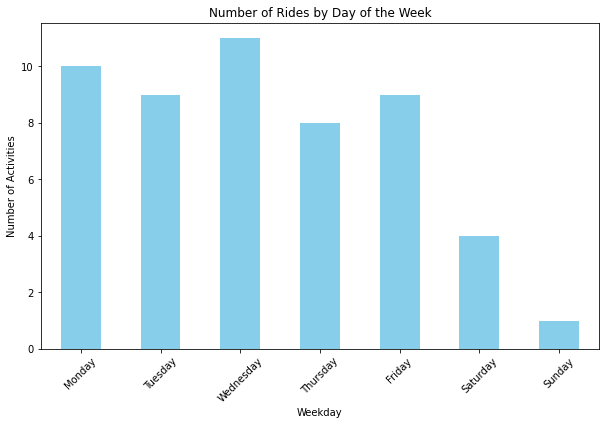

In [34]:
# number of days that fall on each date
combineddf['Weekday'] = combineddf['Date'].dt.day_name()
activity_count = combineddf[combineddf['Cycling Activity (Y/N)'] == 1]['Weekday'].value_counts().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], fill_value=0)
plt.figure(figsize=(10, 6))
activity_count.plot(kind='bar', color='skyblue')
plt.title('Number of Rides by Day of Week')
plt.ylabel('Number of Activities')
plt.xticks(rotation=45)
plt.show()





In [36]:
# Proportion of positive and negative 5 day average values when I've gone for a ride.
# Filter the DataFrame for only where Ive gone riding
filtered_df = combineddf[combineddf['Cycling Activity (Y/N)'] == 1]

# Count the number of positive and negative values in the Min Temp column
positive_count = (filtered_df['5DAvg Difference (Min Temp)'] > 0).sum()
negative_count = (filtered_df['5DAvg Difference (Min Temp)'] < 0).sum()

print("Min Temp")
print(f"Number of positive values: {positive_count}")
print(f"Number of negative values: {negative_count}")

# Count the number of positive and negative values in the Max Temp column
positive_count = (filtered_df['5DAvg Difference (Max Temp)'] > 0).sum()
negative_count = (filtered_df['5DAvg Difference (Max Temp)'] < 0).sum()

print("Max Temp")
print(f"Number of positive values: {positive_count}")
print(f"Number of negative values: {negative_count}")

# Count the number of positive and negative values in the Rainfall column
positive_count = (filtered_df['5DAvg Difference (Rainfall)'] > 0).sum()
negative_count = (filtered_df['5DAvg Difference (Rainfall)'] < 0).sum()

print("Rainfall")
print(f"Number of positive values: {positive_count}")
print(f"Number of negative values: {negative_count}")

# Count the number of positive and negative values in the Wind Speed column
positive_count = (filtered_df['5DAvg Difference (Wind Speed)'] > 0).sum()
negative_count = (filtered_df['5DAvg Difference (Wind Speed)'] < 0).sum()

print("Wind Speed")
print(f"Number of positive values: {positive_count}")
print(f"Number of negative values: {negative_count}")


Min Temp
Number of positive values: 26
Number of negative values: 26
Max Temp
Number of positive values: 22
Number of negative values: 30
Rainfall
Number of positive values: 17
Number of negative values: 26
Wind Speed
Number of positive values: 16
Number of negative values: 35


Temp maybe not playing as big a part as initially believed. But going riding when less rain and less wind.

### Machine Learning


Modeling Approach:

    Time Series Analysis: Using models like ARIMA or LSTM to predict optimal times based on historical performance data.
    Regression Models: To relate weather conditions at different times of day to your performance metrics.
    Clustering: K-means clustering to identify patterns in your riding times and performance.
    

Modeling Approach:

    Descriptive Statistics:
    Time Series Analysis: Identify trends and patterns in your riding frequency and distances over time.
    Classification Models: Predict likelihood of riding based on past habits and current weather (e.g., logistic regression, decision trees).
    Cluster Analysis: Segment your rides into different types (e.g., short commutes, long weekend rides) and analyze habits within each cluster.

### Results

    Optimal Time Suggestions: Recommendations for the best times to ride based on predicted weather conditions and your historical performance.